### Initial Classifier 2022-03
This file processes data, creates features, trains and finally tests our initial model for classifying road LTS in Toronto.
All functions are stored in a seperate python file within the folder

In [2]:
#Import all packages from model functions
from model_functions import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#plt.style.use('dark_background')
plt.style.use('seaborn-colorblind')

Import the data, add the lienar name prefixes/'types'

In [8]:
train_data = pd.read_csv('C:/Users/Keagan Rankin/Documents/PycharmProj/data/training_data/ysign_dropoff2_iter15_train.csv')
train_data.head()

,Unnamed: 0,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,Shape_Leng,geometry,ysign vehicle,ysign ped,high access
0,26720,26722,1137670,3025,Bocastle Ave,13453368,13453237,0,95.530596,1137670,1,0.000883,LINESTRING (628767.3368918777 4843212.59019024...,4790.250,973.25,1
1,45540,45542,111369,8220,Kenmark Blvd,13453101,13453173,0,228.998686,111369,1,0.002671,LINESTRING (639762.0980769163 4843420.41458969...,2446.250,329.25,1
2,14362,14363,14048139,3053,Brandon Ave,13463765,14048141,0,49.852955,14048139,1,0.000607,LINESTRING (625363.2529044797 4836317.83499265...,1582.625,73.25,1
3,36418,36420,2689046,3803,Lake Shore Blvd E,13466078,13466003,0,105.443542,2689046,4,0.001222,LINESTRING (633798.3739368191 4834729.22944054...,1327.250,7.00,0
4,15812,15813,14040464,11872,Ln 1 W Clinton N Gore,14040383,14040467,0,22.935001,14040464,1,0.000214,LINESTRING (627870.1851326771 4834730.84276338...,906.375,451.50,1


In [4]:
#Import the shapefile from open Toronto (see eda_toronto_centrelines)
geojsonpath = 'C:/Users/keaga/PycharmProjects/1498-ML-Project/data/raw_data/centreline_wgs84_geojson_v2/CENTRELINE_WGS84.geojson'
path2 = 'C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/centreline_wgs84_geojson_v2/CENTRELINE_WGS84.geojson'
centrelines_gpd = gpd.read_file(path2)
                                      
centrelines_gpd.head(2)

,CENTRELINE_ID,LINEAR_NAME_ID,LINEAR_NAME_FULL,LINEAR_NAME_FULL_LEGAL,ADDRESS_L,ADDRESS_R,PARITY_L,PARITY_R,LO_NUM_L,HI_NUM_L,...,ONEWAY_DIR_CODE,ONEWAY_DIR_CODE_DESC,FEATURE_CODE,FEATURE_CODE_DESC,JURISDICTION,CENTRELINE_STATUS,OBJECTID,MI_PRINX,Shape__Length,geometry
0,14646677,4807,Antibes Dr,Antibes Drive,None,None,N,N,NaN,NaN,...,0,Not One-Way,201400,Collector,CITY OF TORONTO,None,419,419,3.922905,"LINESTRING (-79.45043 43.78194, -79.45039 43.7..."
1,14257954,11624,427 X S Gardiner X E Ramp,427 X S Gardiner X E Ramp,None,None,N,N,NaN,NaN,...,1,Follow-Digitization,201101,Expressway Ramp,PROVINCE,None,617,617,4.056786,"LINESTRING (-79.54894 43.61345, -79.54890 43.6..."


In [9]:
train_data = pd.merge(train_data,
                      centrelines_gpd[['CENTRELINE_ID','LINEAR_NAME_TYPE']],
                      how='left',
                      left_on='GEO_ID',
                      right_on='CENTRELINE_ID',
                     )

train_data['LINEAR_NAME_TYPE'] = train_data['LINEAR_NAME_TYPE'].fillna('no type')
train_data.head()

,Unnamed: 0,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,Shape_Leng,geometry,ysign vehicle,ysign ped,high access,CENTRELINE_ID,LINEAR_NAME_TYPE
0,26720,26722,1137670,3025,Bocastle Ave,13453368,13453237,0,95.530596,1137670,1,0.000883,LINESTRING (628767.3368918777 4843212.59019024...,4790.250,973.25,1,1137670.0,Ave
1,45540,45542,111369,8220,Kenmark Blvd,13453101,13453173,0,228.998686,111369,1,0.002671,LINESTRING (639762.0980769163 4843420.41458969...,2446.250,329.25,1,111369.0,Blvd
2,14362,14363,14048139,3053,Brandon Ave,13463765,14048141,0,49.852955,14048139,1,0.000607,LINESTRING (625363.2529044797 4836317.83499265...,1582.625,73.25,1,14048139.0,Ave
3,36418,36420,2689046,3803,Lake Shore Blvd E,13466078,13466003,0,105.443542,2689046,4,0.001222,LINESTRING (633798.3739368191 4834729.22944054...,1327.250,7.00,0,2689046.0,Blvd
4,15812,15813,14040464,11872,Ln 1 W Clinton N Gore,14040383,14040467,0,22.935001,14040464,1,0.000214,LINESTRING (627870.1851326771 4834730.84276338...,906.375,451.50,1,14040464.0,no type


### Clean data and create features using the functions in the import file

In [10]:
# Split features and target
y_train_lts = train_data['LTS']
y_train_access = train_data['high access']
X_train = train_data.drop(['LTS','high access'], axis=1)

In [11]:
# Run the feature creation functions from imports
keep_rows = ['OBJECTID', 'GEO_ID', 'geometry', 'ysign vehicle', 'ysign ped', 'LINEAR_NAME_TYPE']
X_train = droprows(X_train, keep_rows)
X_train = add_regions(X_train, 2, 4)
X_train = scale_and_dummy(X_train, ['ysign vehicle', 'ysign ped'], ['x_region', 'y_region','LINEAR_NAME_TYPE'])
X_train.head()

Principal component 0
explains 74.76311274393491 % of the variance in "lon" and "lat".
Principal component 1
explains 25.236887256065092 % of the variance in "lon" and "lat".


,OBJECTID,GEO_ID,geometry,ysign vehicle,ysign ped,x_region_2,x_region_3,x_region_4,y_region_2,y_region_3,...,LINEAR_NAME_TYPE_St,LINEAR_NAME_TYPE_Ter,LINEAR_NAME_TYPE_Trl,LINEAR_NAME_TYPE_View,LINEAR_NAME_TYPE_Walk,LINEAR_NAME_TYPE_Way,LINEAR_NAME_TYPE_Wds,LINEAR_NAME_TYPE_Wkwy,LINEAR_NAME_TYPE_Wood,LINEAR_NAME_TYPE_no type
0,26722,1137670,"LINESTRING (628767.337 4843212.590, 628742.286...",0.094336,0.258095,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,45542,111369,"LINESTRING (639762.098 4843420.415, 639798.062...",-0.330468,-0.118231,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,14363,14048139,"LINESTRING (625363.253 4836317.835, 625315.575...",-0.486982,-0.267827,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,36420,2689046,"LINESTRING (633798.374 4834729.229, 633887.623...",-0.533264,-0.306540,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15813,14040464,"LINESTRING (627870.185 4834730.843, 627863.091...",-0.609539,-0.046794,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


Define the models - choose betwene different classification models

In [12]:
model_log = LogisticRegression()
model_svm = svm.SVC()
model_rf = RandomForestClassifier()

Select Features: use selectKbest or a built in selector in regularization or random forest

In [13]:
features = X_train.columns.values[3:]

Fit a basic model

Advanced Cross Validation: use a function that bins by area?

Tune Hyper Parameters

In [15]:
cv = StratifiedKFold(n_splits=10)

# Choose hyper-params
params_log = {'penalty': ('l1', 'l2'),
              'fit_intercept': (True, False),
              'C': loguniform(1e-3, 1e2),
              'class_weight': (None, 'balanced')
             }

# Do the search (might take awhile)
r_search_log = RandomizedSearchCV(estimator=model_log,
                                  param_distributions=params_log,
                                  n_iter=10,
                                  scoring='f1_weighted',
                                  cv=cv,
                                 )

r_search_log.fit(X_train[features], y_train_access)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=LogisticRegression(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C98912DCA0>,
                                        'class_weight': (None, 'balanced'),
                                        'fit_intercept': (True, False),
                                        'penalty': ('l1', 'l2')},
                   scoring='f1_weighted')

In [16]:
print('best weighted score', r_search_log.best_score_)
print('best estimator: ',r_search_log.best_estimator_)

best weighted score 0.8236450100066804
best estimator:  LogisticRegression(C=11.569768236989306, fit_intercept=False)


In [17]:
model_baseline = LogisticRegression(C=11.569768236989306, fit_intercept=False)
model_baseline.fit(X_train[features], y_train_access)

y_pred = model_baseline.predict(X_train[features])

### Evaluate the Baseline model

Visualize the decision boundary:

In [18]:
print('accuracy: ', accuracy_score(y_train_access, y_pred))
print('weighted f1: ', f1_score(y_train_access, y_pred, average='weighted'))

accuracy:  0.8441467897661251
weighted f1:  0.8234506004515308


ValueError: X has 2 features, but LogisticRegression is expecting 1 features as input.

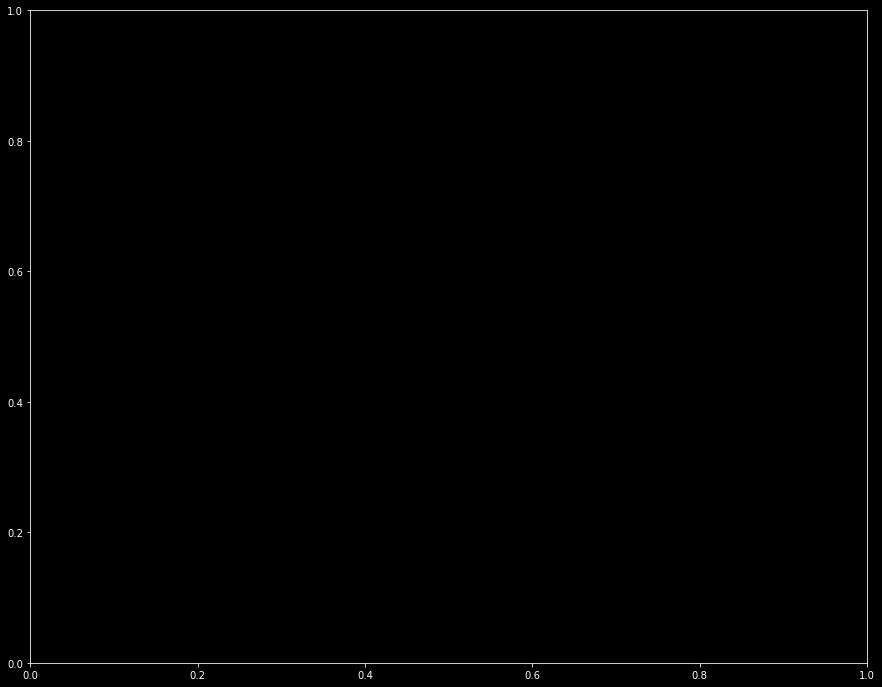

In [57]:
# Create np meshgrid.
xx, yy = np.mgrid[-2:10:.01, -1:30:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
#probs = model_baseline.predict_proba(grid)[:, 1].reshape(xx.shape)

# Plot results
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Figure
f, ax = plt.subplots(figsize=(15, 12))
plot_contours(ax, model_baseline, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
#ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

#Plot
ax.scatter(X_train['ysign vehicle'], X_train['ysign ped'], c=y_train_access, s=50,
           cmap="coolwarm", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1, label='high access')

# Parameters
ax.grid(False)
ax.set_ylabel('Scaled Ped YSIGN')
ax.set_xlabel('Scaled Vehicle YSIGN')
ax.legend()

plt.show()

Plot the confusion matrix, threshold, and roc curve.

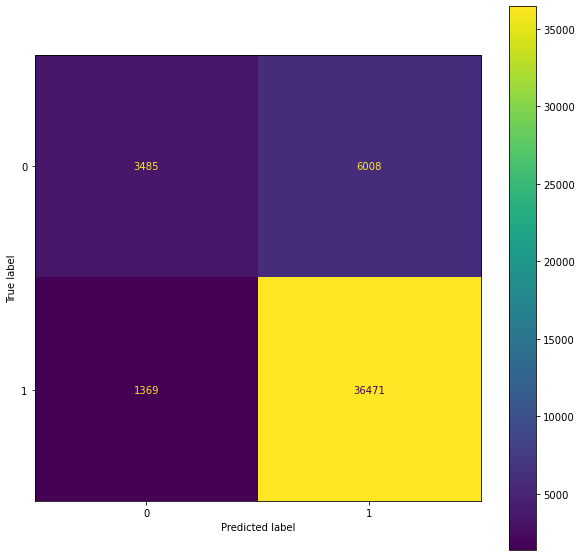

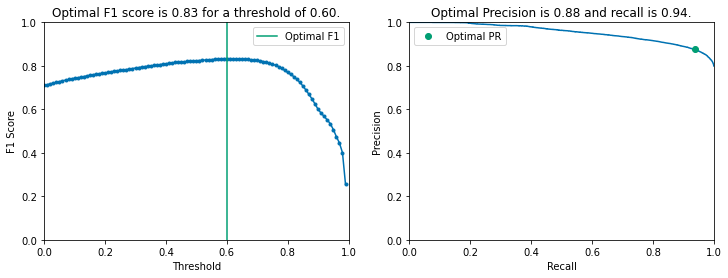

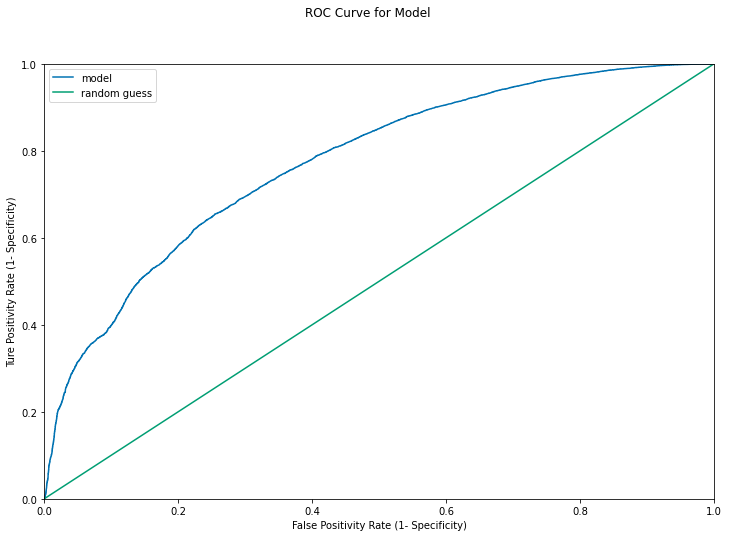

In [19]:
# Confusion matrix
f, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model_baseline, X_train[features], y_train_access, ax=ax)
ax.grid(False)

#Weighted F1 score with optimal threshold if relevant
plot_f1_threshold(X_train[features], y_train_access, model_baseline)

#roc curve
plot_roc(y_train_lts, model_baseline.predict_proba(X_train[features]))

Plot the correctly and incorrectly classified data

In [20]:
predicted = pd.Series(y_pred)
predicted = pd.concat((train_data, predicted), axis=1)

In [21]:
lts_gpd = gpd.read_file('C:/Users/Keagan Rankin/Documents/PycharmProj/data/raw_data/Bo Github Data/centerline_LTS_July2021.shp')
lts_gpd = lts_gpd[lts_gpd['LTS'] != 0]
lts_gpd['high access'] = lts_gpd['LTS'].apply(lambda x: 1 if x <= 2 else 0)

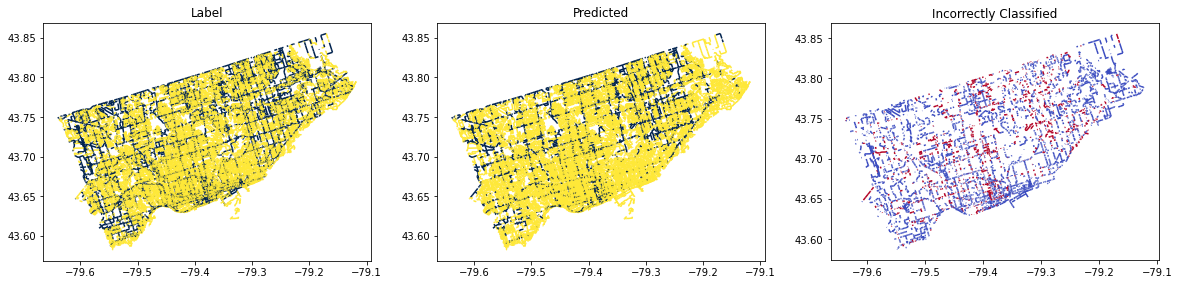

In [23]:
# Plot the above to show the new data. Show with 4 LTS and with the high/low access grouping
# Geoframe
plotr = pd.merge(lts_gpd,
                 predicted[['GEO_ID',0]],
                 how='left',
                 left_on='GEO_ID',
                 right_on='GEO_ID',)

# Find the difference in classification
plotr = plotr.dropna()
plotr['diff'] = plotr['high access'] - plotr[0]
plotr['i or c'] = plotr['diff'].apply(lambda x: 'incorrect' if x != 0 else 'correct')
plotr_diff = plotr[plotr['diff'] != 0]

# Figure
fig, axs = plt.subplots(figsize=(20,12), ncols=3)

# Plotting
plotr.plot(ax=axs[0], column='high access', cmap='cividis')
plotr.plot(ax=axs[1], column=0, cmap='cividis')
#plotr[plotr['i or c'] == 'incorrect'].plot(ax=axs[2], column='i or c', cmap='coolwarm')
plotr_diff.plot(ax=axs[2], column='diff', cmap='coolwarm')

# Attributes
axs[0].title.set_text('Label')
axs[1].title.set_text('Predicted')
axs[2].title.set_text('Incorrectly Classified')
axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

plt.show()

Notes:
The baseline model with one feature has an okay weighted f1 for the binary classification (0.82), but it is really quite bad at predicting roads with low accessibility; it mislabels most of these (6689 vs 2804 correct) at a dropoff coefficient of 2. A higher dropoff actually makes the model worse (meaning we are probably mis classifying even more low access high volume roads). Lowering the dropoff seems to perform even worse (8000 misclassified at dropoff of 1.25), probably because the data is coming closer together. It seems like ~2 is the best value for a dropoff with just the ysign data.